In [ ]:
import sys
import pandas as pd
import numpy as np
import os
from scipy.ndimage import rotate
import scipy.ndimage
from joblib import Parallel, delayed
import multiprocessing
import itertools
import pydicom
import SimpleITK as sitk
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split

#Code from existing github repo provided by UC Irvine dataset
sys.path.append(os.getcwd())
import utils
import equalizer
from utils import cutCube
from equalizer import histEq

In [ ]:
# Modified DICOM loading functions for newer pydicom versions
def load_scan(path2scan):
    if (path2scan.split('.')[-1] == 'mhd') or (path2scan.split('.')[-1] == 'raw'):
        return load_mhd(path2scan)
    elif path2scan.split('.')[-1] == 'dcm':
        return load_dicom(os.path.split(path2scan)[0]) #pass containing directory
    elif os.path.isdir(path2scan) and any(f.endswith('.dcm') for f in os.listdir(path2scan)):
        return load_dicom(path2scan)
    else:
        raise Exception('No valid scan [series] found in given file/directory')

def load_mhd(path2scan):
    itkimage = sitk.ReadImage(path2scan)
    scan = sitk.GetArrayFromImage(itkimage)
    spacing = np.flip(np.array(itkimage.GetSpacing()),axis=0)
    orientation = np.transpose(np.array(itkimage.GetDirection()).reshape((3, 3)))
    origin = np.flip(np.array(itkimage.GetOrigin()),axis=0)
    return scan, spacing, orientation, origin, None

def load_dicom(path2scan_dir):
    dicom_folder = path2scan_dir
    dcms = [f for f in os.listdir(dicom_folder) if f.endswith('.dcm')]
    if not dcms:
        raise Exception(f"No DICOM files found in {dicom_folder}")

    first_slice_data = pydicom.dcmread(os.path.join(path2scan_dir, dcms[0]))
    first_slice = first_slice_data.pixel_array
    orientation = np.transpose(first_slice_data.ImageOrientationPatient)
    spacing_xy = np.array(first_slice_data.PixelSpacing, dtype=float)
    spacing_z = float(first_slice_data.SliceThickness)
    spacing = np.array([spacing_z, spacing_xy[1], spacing_xy[0]])

    scan = np.zeros((len(dcms), first_slice.shape[0], first_slice.shape[1]))
    raw_slices = []
    indexes = []

    for dcm in dcms:
        slice_data = pydicom.dcmread(os.path.join(dicom_folder, dcm))
        slice_data.filename = dcm
        raw_slices.append(slice_data)
        indexes.append(float(slice_data.ImagePositionPatient[2]))

    indexes = np.array(indexes, dtype=float)
    raw_slices = [x for _, x in sorted(zip(indexes, raw_slices))]

    try:
        origin = np.array(raw_slices[0][0x00200032].value)
        origin = np.array([origin[2], origin[1], origin[0]])
    except:
        origin = np.zeros(3)

    for i, slice_obj in enumerate(raw_slices):
        scan[i, :, :] = slice_obj.pixel_array

    return scan, spacing, orientation, origin, raw_slices

def scale_scan(scan, spacing, factor=1):
    resize_factor = factor * spacing
    new_real_shape = scan.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / scan.shape
    new_spacing = spacing / real_resize_factor
    scan_resized = scipy.ndimage.zoom(scan, real_resize_factor, mode='nearest')
    return scan_resized, resize_factor

def get_scaled_shape(shape, spacing):
    new_real_shape = shape * spacing
    return np.round(new_real_shape).astype(int)

def world2vox(world_coord, spacing, orientation, origin):
    world_coord = np.dot(np.linalg.inv(np.dot(orientation, np.diag(spacing))), world_coord - origin)
    if orientation[0, 0] < 0:
        vox_coord = (np.array([world_coord[0], world_coord[2], world_coord[1]])).astype(int)
    else:
        vox_coord = (np.array([world_coord[0], world_coord[1], world_coord[2]])).astype(int)
    return vox_coord

In [ ]:
class CombinedLabeledExtractor:
    """
    Extractor that combines multiple experiments into one dataset
    Modified to split data BEFORE augmentation
    """
    def __init__(self, 
                 experiments_config,  
                 dst_path, 
                 norm_save_dir,
                 cube_shape=(32, 32, 32),
                 parallelize=False,
                 coordSystem='vox',
                 include_types=['FB', 'FM', 'TM','TB'],
                 augment=True,
                 train_ratio=0.6,
                 val_ratio=0.2,
                 test_ratio=0.2,
                 random_state=42):
        """
        Args:
            experiments_config: List of experiment configurations
            dst_path: Where to save the combined processed dataset
            norm_save_dir: Where to save normalization parameters
            cube_shape: Size of extracted 3D cubes
            parallelize: Whether to use multiprocessing
            coordSystem: 'vox' for voxel coordinates
            include_types: Which finding types to include
            augment: Whether to perform data augmentation (only on training set)
            train_ratio: Proportion of data for training
            val_ratio: Proportion of data for validation
            test_ratio: Proportion of data for testing
            random_state: Random seed for reproducibility
        """
        self.experiments_config = experiments_config
        self.dst_path = dst_path
        self.norm_save_dir = norm_save_dir
        self.cube_shape = cube_shape
        self.parallelize = parallelize
        self.coordSystem = coordSystem
        self.include_types = include_types
        self.augment = augment
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.random_state = random_state
        
        # Load and combine labels from all experiments
        self.combined_labels_df = pd.DataFrame()
        
        for exp_config in experiments_config:
            print(f"\nLoading labels for {exp_config['experiment_name']}...")
            
            # Load labels for this experiment
            labels_df = pd.read_csv(exp_config['labels_csv'])
            
            # Add experiment identifier
            labels_df['experiment'] = exp_config['experiment_name']
            labels_df['dicom_base_dir'] = exp_config['dicom_dir']
            
            # Filter by type
            labels_df = labels_df[labels_df['type'].isin(include_types)]
            
            # Filter out TB entries with 0,0,0 coordinates
            # labels_df = labels_df[~((labels_df['type'] == 'TB') &
            #                        (labels_df['x'] == 0) &
            #                        (labels_df['y'] == 0) &
            #                        (labels_df['slice'] == 0))]
            #
            print(f"Loaded {len(labels_df)} samples from {exp_config['experiment_name']}")
            print(f"Types distribution:\n{labels_df['type'].value_counts()}")
            
            # Combine with existing labels
            self.combined_labels_df = pd.concat([self.combined_labels_df, labels_df], 
                                                ignore_index=True)
        
        print(f"\nTotal combined samples: {len(self.combined_labels_df)}")
        print(f"Combined types distribution:\n{self.combined_labels_df['type'].value_counts()}")
        print(f"Samples per experiment:\n{self.combined_labels_df['experiment'].value_counts()}")

    def extract(self, plot=True):
        """Extract and process all labeled samples from all experiments"""
        print("\nPreparing extraction jobs for combined dataset...")
        
        # create train/val/test split on the original data
        train_df, val_df, test_df = self._create_data_splits()
        
        # Process each split separately
        splits_data = {}
        
        for split_name, split_df, apply_augment in [
            ('train', train_df, self.augment),
            ('val', val_df, False),
            ('test', test_df, False)
        ]:
            print(f"\n{'='*50}")
            print(f"Processing {split_name} set ({len(split_df)} samples)...")
            print(f"Augmentation: {'ON' if apply_augment else 'OFF'}")
            
            instances, labels, experiments = self._process_split(split_df, apply_augment)
            
            if len(instances) == 0:
                print(f"ERROR: No instances were successfully extracted for {split_name}!")
                continue
            
            splits_data[split_name] = {
                'instances': instances,
                'labels': labels,
                'experiments': experiments
            }
            
            print(f"Successfully extracted {len(instances)} instances for {split_name}")
        
        # Combine all splits for normalization (but keep track of indices)
        all_instances = []
        split_indices = {}
        current_idx = 0
        
        for split_name in ['train', 'val', 'test']:
            if split_name in splits_data:
                split_size = len(splits_data[split_name]['instances'])
                split_indices[split_name] = (current_idx, current_idx + split_size)
                all_instances.extend(splits_data[split_name]['instances'])
                current_idx += split_size
        
        all_instances = np.array(all_instances)
        
        # Preprocessing on all data
        print("\n\nEqualizing the data across all splits...")
        eq = histEq(all_instances)
        all_instances = eq.equalize(all_instances)
        os.makedirs(self.norm_save_dir, exist_ok=True)
        eq.save(path=os.path.join(self.norm_save_dir, 'equalization.pkl'))

        print("Normalizing the data...")
        min_v = np.min(all_instances)
        max_v = np.max(all_instances)
        mean_v = np.mean(all_instances)
        norm_data = np.array([mean_v, min_v, max_v])
        all_instances = (all_instances - mean_v) / (max_v - min_v)
        np.save(os.path.join(self.norm_save_dir, 'normalization.npy'), norm_data)
        
        # Split back the normalized data
        for split_name, (start_idx, end_idx) in split_indices.items():
            splits_data[split_name]['instances'] = all_instances[start_idx:end_idx]
        
        # Save each split separately
        print("\n\nSaving the split datasets...")
        
        for split_name in ['train', 'val', 'test']:
            if split_name in splits_data:
                split_path = self.dst_path.replace('.npy', f'_{split_name}.npy')
                np.save(split_path, splits_data[split_name]['instances'])
                np.save(split_path.replace('.npy', '_labels.npy'), splits_data[split_name]['labels'])
                np.save(split_path.replace('.npy', '_experiments.npy'), splits_data[split_name]['experiments'])
                
                print(f"Saved {split_name} set: {len(splits_data[split_name]['instances'])} samples")
        
        # Save metadata
        metadata = {
            'label_mapping': {label: int(idx) for idx, label in enumerate(np.unique(self.combined_labels_df['type']))},
            'experiment_info': {exp: int(idx) for idx, exp in enumerate(np.unique(self.combined_labels_df['experiment']))},
            'split_sizes': {
                split_name: len(splits_data[split_name]['instances']) 
                for split_name in splits_data
            },
            'split_ratios': {
                'train': self.train_ratio,
                'val': self.val_ratio,
                'test': self.test_ratio
            },
            'augmentation_applied': {
                'train': self.augment,
                'val': False,
                'test': False
            },
            'random_state': self.random_state
        }
        
        import json
        with open(self.dst_path.replace('.npy', '_metadata.json'), 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print(f"\nLabel mapping: {metadata['label_mapping']}")
        print(f"Experiment mapping: {metadata['experiment_info']}")
        print(f"\nFinal split sizes:")
        for split_name, size in metadata['split_sizes'].items():
            print(f"  {split_name}: {size} samples")
        
        if plot:
            self._plot_split_distributions(splits_data)
        
        return splits_data, metadata

    def _create_data_splits(self):
        """Create train/val/test splits with stratification"""
        print("\nCreating train/val/test splits...")
        
        # Create stratification key combining type and experiment
        self.combined_labels_df['stratify_key'] = (
            self.combined_labels_df['type'] + '_' + 
            self.combined_labels_df['experiment']
        )
        
        # First split: train+val vs test
        train_val_df, test_df = train_test_split(
            self.combined_labels_df,
            test_size=self.test_ratio,
            stratify=self.combined_labels_df['stratify_key'],
            random_state=self.random_state
        )
        
        # Second split: train vs val
        val_size_adjusted = self.val_ratio / (self.train_ratio + self.val_ratio)
        train_df, val_df = train_test_split(
            train_val_df,
            test_size=val_size_adjusted,
            stratify=train_val_df['stratify_key'],
            random_state=self.random_state
        )
        
        print(f"Split sizes:")
        print(f"  Train: {len(train_df)} samples ({len(train_df)/len(self.combined_labels_df)*100:.1f}%)")
        print(f"  Val: {len(val_df)} samples ({len(val_df)/len(self.combined_labels_df)*100:.1f}%)")
        print(f"  Test: {len(test_df)} samples ({len(test_df)/len(self.combined_labels_df)*100:.1f}%)")
        
        # Print distribution per split
        for split_name, split_df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
            print(f"\n{split_name} set distribution:")
            print(split_df['type'].value_counts())
        
        return train_df, val_df, test_df

    def _process_split(self, split_df, apply_augment):
        """Process a single data split"""
        jobs = []
        labels = []
        experiments = []
        
        for idx, row in split_df.iterrows():
            # Build path to DICOM scan
            scan_path = os.path.join(row['dicom_base_dir'], str(row['uuid']))
            scan_path = os.path.normpath(scan_path)
            
            # Coordinate in z,y,x format
            coord = np.array([row['slice'], row['y'], row['x']])
            
            # Job format: [scan_path, coord, cube_shape, coordSystem, label_type, apply_augment]
            jobs.append([scan_path, coord, self.cube_shape, self.coordSystem, row['type'], apply_augment])
            labels.append(row['type'])
            experiments.append(row['experiment'])
        
        print(f"Extracting {len(jobs)} samples...")
        
        if self.parallelize:
            num_cores = int(np.ceil(min(np.ceil(multiprocessing.cpu_count() * 0.75), len(jobs))))
            results = Parallel(n_jobs=num_cores)(delayed(self._process_job)(job) for job in jobs)
        else:
            results = []
            for i, job in enumerate(jobs):
                try:
                    result = self._process_job(job)
                    results.append(result)
                    if i % 10 == 0:
                        print(f"Processed {i+1}/{len(jobs)} samples")
                except Exception as e:
                    print(f"Failed to process sample {job[0]}: {e}")
                    results.append(None)
        
        # Collect successful extractions
        instances = []
        instance_labels = []
        instance_experiments = []
        
        for i, result in enumerate(results):
            if result is not None:
                cubes, label_type = result
                instances.extend(cubes)
                instance_labels.extend([label_type] * len(cubes))
                instance_experiments.extend([experiments[i]] * len(cubes))
        
        return np.array(instances), np.array(instance_labels), np.array(instance_experiments)

    def _process_job(self, args):
        """Process single extraction job"""
        scan_path, coord, cube_shape, coordSystem, label_type, apply_augment = args
        
        try:
            # Load scan
            scan, spacing, orientation, origin, raw_slices = load_scan(scan_path)
            
            # Convert coordinates if needed
            if coordSystem == 'world':
                coord = world2vox(coord, spacing, orientation, origin)
            
            # Extract the base cube with padding
            init_cube_shape = get_scaled_shape(np.array(cube_shape) + 8, 1/spacing)
            clean_cube_unscaled = cutCube(scan, coord, init_cube_shape, padd=-1000)
            
            # Scale the cube
            scaled_cube, resize_factor = scale_scan(clean_cube_unscaled, spacing)
            
            # Data augmentation (only if specified)
            if apply_augment:
                augmented_cubes = self._augment_instance(scaled_cube)
            else:
                augmented_cubes = [scaled_cube]
            
            # Trim to final shape
            final_cubes = []
            for cube in augmented_cubes:
                center = np.array(cube.shape) // 2
                final_cube = cutCube(cube, center, cube_shape, padd=-1000)
                if final_cube.shape == tuple(cube_shape):
                    final_cubes.append(final_cube)
            
            return final_cubes, label_type
            
        except Exception as e:
            print(f"Error processing {scan_path}: {e}")
            return None

    def _augment_instance(self, x0):
        """Data augmentation"""
        augmented = [x0]  # Original
        
        # Flips
        augmented.append(np.flip(x0, 1))  # x flip
        augmented.append(np.flip(x0, 2))  # y flip
        
        # Small shifts
        augmented.append(scipy.ndimage.shift(x0, (0, 2, 2), mode='constant'))
        augmented.append(scipy.ndimage.shift(x0, (0, -2, 2), mode='constant'))
        
        # Small rotations
        for angle in [15, 30, 45, 90, 180]:
            rotated = rotate(x0, angle, axes=(1, 2), mode='reflect', reshape=False)
            augmented.append(rotated)
        
        # Filter out invalid shapes
        valid_cubes = []
        for cube in augmented:
            if cube.shape[0] > 0 and cube.shape[1] > 0 and cube.shape[2] > 0:
                valid_cubes.append(cube)
        
        return valid_cubes

    def _plot_split_distributions(self, splits_data):
        """Plot distributions for each split"""
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot 1: Sample counts per split
        split_names = list(splits_data.keys())
        split_sizes = [len(splits_data[s]['instances']) for s in split_names]
        
        axes[0, 0].bar(split_names, split_sizes, color=['#2E86AB', '#A23B72', '#F18F01'])
        axes[0, 0].set_title('Sample Count per Split', fontsize=14, fontweight='bold')
        axes[0, 0].set_ylabel('Number of Samples')
        
        for i, (name, size) in enumerate(zip(split_names, split_sizes)):
            axes[0, 0].text(i, size + 10, str(size), ha='center', fontweight='bold')
        
        # Plot 2: Type distribution per split
        width = 0.25
        x = np.arange(len(split_names))
        
        unique_types = ['FB', 'FM', 'TM','TB']
        colors = {'FB': '#FF6B6B', 'FM': '#4ECDC4', 'TM': '#45B7D1','TB':'#6BFFFF'}
        
        for i, ttype in enumerate(unique_types):
            counts = []
            for split_name in split_names:
                type_count = np.sum(splits_data[split_name]['labels'] == ttype)
                counts.append(type_count)
            
            axes[0, 1].bar(x + i*width, counts, width, label=ttype, color=colors[ttype])
        
        axes[0, 1].set_xlabel('Split')
        axes[0, 1].set_ylabel('Number of Samples')
        axes[0, 1].set_title('Type Distribution per Split', fontsize=14, fontweight='bold')
        axes[0, 1].set_xticks(x + width)
        axes[0, 1].set_xticklabels(split_names)
        axes[0, 1].legend()
        
        # Plot 3: Experiment distribution per split
        unique_experiments = ['Experiment_1', 'Experiment_2']
        exp_colors = ['#8B5A3C', '#6B8E23']
        
        for i, exp in enumerate(unique_experiments):
            counts = []
            for split_name in split_names:
                exp_count = np.sum(splits_data[split_name]['experiments'] == exp)
                counts.append(exp_count)
            
            axes[1, 0].bar(x + i*width*1.5, counts, width*1.5, label=exp, color=exp_colors[i])
        
        axes[1, 0].set_xlabel('Split')
        axes[1, 0].set_ylabel('Number of Samples')
        axes[1, 0].set_title('Experiment Distribution per Split', fontsize=14, fontweight='bold')
        axes[1, 0].set_xticks(x + width*0.75)
        axes[1, 0].set_xticklabels(split_names)
        axes[1, 0].legend()
        
        # Plot 4: Augmentation effect (for training set)
        if 'train' in splits_data:
            train_labels = splits_data['train']['labels']
            unique_labels, counts = np.unique(train_labels, return_counts=True)
            
            # Estimate original counts (before augmentation)
            # This is approximate based on the augmentation factor
            original_train_size = len(self.combined_labels_df) * self.train_ratio
            augmentation_factor = len(train_labels) / original_train_size
            
            axes[1, 1].text(0.5, 0.5, f'Training Set Augmentation\n\nOriginal: ~{int(original_train_size)} samples\n'
                           f'After Augmentation: {len(train_labels)} samples\n'
                           f'Augmentation Factor: ~{augmentation_factor:.1f}x',
                           ha='center', va='center', fontsize=12,
                           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
            axes[1, 1].set_title('Augmentation Summary', fontsize=14, fontweight='bold')
            axes[1, 1].axis('off')
        
        plt.tight_layout()
        plt.suptitle('Data Split Analysis', fontsize=16, fontweight='bold', y=1.02)
        plt.show()


In [ ]:
class CombinedDataLoader:
    """
    Data loader for combined dataset with split support
    """
    def __init__(self, dataset_base_path, normdata_path, img_res=(32, 32, 32)):
        self.dataset_base_path = dataset_base_path
        self.normdata_path = normdata_path
        self.img_res = img_res
        self.splits = {}
        
        # Load metadata
        import json
        metadata_path = dataset_base_path.replace('.npy', '_metadata.json')
        with open(metadata_path, 'r') as f:
            self.metadata = json.load(f)
        
        # Load each split
        for split in ['train', 'val', 'test']:
            split_path = dataset_base_path.replace('.npy', f'_{split}.npy')
            if os.path.exists(split_path):
                print(f"\nLoading {split} set...")
                
                data = np.load(split_path)
                labels = np.load(split_path.replace('.npy', '_labels.npy'))
                experiments = np.load(split_path.replace('.npy', '_experiments.npy'))
                
                # Format for neural network
                data = data.reshape((len(data), self.img_res[0], self.img_res[1], self.img_res[2], 1))
                
                # Convert labels to indices
                label_to_idx = self.metadata['label_mapping']
                label_indices = np.array([label_to_idx[label] for label in labels])
                
                self.splits[split] = {
                    'data': data,
                    'labels': labels,
                    'label_indices': label_indices,
                    'experiments': experiments
                }
                
                print(f"Loaded {len(data)} samples for {split}")
                print(f"Label distribution: {dict(zip(*np.unique(labels, return_counts=True)))}")
    
    def get_split(self, split_name):
        """Get a specific split"""
        if split_name not in self.splits:
            raise ValueError(f"Split '{split_name}' not found. Available splits: {list(self.splits.keys())}")
        return self.splits[split_name]
    
    def load_batch(self, split_name='train', batch_size=32, shuffle=True):
        """Load batches from a specific split"""
        if split_name not in self.splits:
            raise ValueError(f"Split '{split_name}' not found")
        
        split_data = self.splits[split_name]
        data = split_data['data']
        labels = split_data['label_indices']
        
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)
        
        n_batches = len(indices) // batch_size
        
        for i in range(n_batches):
            batch_indices = indices[i * batch_size:(i + 1) * batch_size]
            batch_data = data[batch_indices]
            batch_labels = labels[batch_indices]
            
            yield batch_data, batch_labels

In [ ]:
if __name__ == "__main__":
    # Configuration for combined dataset
    base_path = os.path.expanduser("~/PycharmProjects/PythonProject/MIDS_207_Final_Project/deepfakes+medical+image+tamper+detection/data/Tampered Scans/")
    
    # Define experiments configuration
    experiments_config = [
        {
            'labels_csv': os.path.join(base_path, "labels_exp_1_TB.csv"),
            'dicom_dir': os.path.join(base_path, "Experiment 1 - Blind"),
            'experiment_name': 'Experiment_1'
        },
        {
            'labels_csv': os.path.join(base_path, "labels_exp_2_TB.csv"),
            'dicom_dir': os.path.join(base_path, "Experiment 2 - Open"),
            'experiment_name': 'Experiment_2'
        }
    ]
    
    output_dataset = "combined_tampered_scans_dataset.npy"
    normalization_dir = "combined_tampered_scans_normalization"
    
    # Extract and preprocess combined dataset with split-first approach
    extractor = CombinedLabeledExtractor(
        experiments_config=experiments_config,
        dst_path=output_dataset,
        norm_save_dir=normalization_dir,
        cube_shape=(32, 32, 32),
        include_types=['FB', 'FM', 'TM','TB'],
        augment=True,  # Will only be applied to training set
        parallelize=False,
        train_ratio=0.6,
        val_ratio=0.2,
        test_ratio=0.2,
        random_state=42
    )
    
    splits_data, metadata = extractor.extract()
    
    # Load the split datasets
    if splits_data is not None:
        dataloader = CombinedDataLoader(
            dataset_base_path=output_dataset,
            normdata_path=normalization_dir
        )

In [1]:
import sys
import pandas as pd
import numpy as np
import os
from scipy.ndimage import rotate
import scipy.ndimage
from joblib import Parallel, delayed
import multiprocessing
import itertools
import pydicom
import SimpleITK as sitk
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split

#Code from existing github repo provided by UC Irvine dataset
sys.path.append(os.getcwd())
import utils
import equalizer
from utils import cutCube
from equalizer import histEq


In [2]:
processed_training_data = "/Users/ugorur/PycharmProjects/PythonProject/MIDS_207_Final_Project/combined_tampered_scans_dataset_train.npy"
processed_training_labels = "/Users/ugorur/PycharmProjects/PythonProject/MIDS_207_Final_Project/combined_tampered_scans_dataset_train_labels.npy"

processed_val_data = "/Users/ugorur/PycharmProjects/PythonProject/MIDS_207_Final_Project/combined_tampered_scans_dataset_val.npy"
processed_val_labels = "/Users/ugorur/PycharmProjects/PythonProject/MIDS_207_Final_Project/combined_tampered_scans_dataset_val_labels.npy"

processed_test_data = "/Users/ugorur/PycharmProjects/PythonProject/MIDS_207_Final_Project/combined_tampered_scans_dataset_test.npy"
processed_test_labels = "/Users/ugorur/PycharmProjects/PythonProject/MIDS_207_Final_Project/combined_tampered_scans_dataset_test_labels.npy"


In [3]:
from sklearn.preprocessing import LabelEncoder

# Loading Training data
loaded_train_data = np.load(processed_training_data)
loaded_train_labels = np.load(processed_training_labels)

# Loading Validation data
loaded_val_data = np.load(processed_val_data)
loaded_val_labels = np.load(processed_val_labels)

# Loading Test data
loaded_test_data = np.load(processed_test_data)
loaded_test_labels = np.load(processed_test_labels)

le = LabelEncoder()
transformed_train_labels = le.fit_transform(loaded_train_labels)
transformed_val_labels = le.transform(loaded_val_labels)
transformed_test_labels = le.transform(loaded_test_labels)

print(f'Shape of training data: {loaded_train_data.shape}, Shape of training labels: {transformed_train_labels.shape}')
print(f'Shape of validation data: {loaded_val_data.shape}, Shape of training labels: {transformed_val_labels.shape}')
print(f'Shape of training data: {loaded_test_data.shape}, Shape of training labels: {transformed_test_labels.shape}')


Shape of training data: (970, 32, 32, 32), Shape of training labels: (970,)
Shape of validation data: (33, 32, 32, 32), Shape of training labels: (33,)
Shape of training data: (33, 32, 32, 32), Shape of training labels: (33,)


In [4]:
train_middle_slices = loaded_train_data[:, 16, :, :]
val_middle_slices = loaded_val_data[:, 16, :, :]
test_middle_slices = loaded_test_data[:, 16, :, :]

print(f'Shape of middle slices: {train_middle_slices.shape}')
print(f'Shape of middle slices: {val_middle_slices.shape}')
print(f'Shape of middle slices: {test_middle_slices.shape}')


Shape of middle slices: (970, 32, 32)
Shape of middle slices: (33, 32, 32)
Shape of middle slices: (33, 32, 32)


In [5]:
train_images = train_middle_slices[:,:,:,np.newaxis]
val_images = val_middle_slices[:,:,:,np.newaxis]
test_images = test_middle_slices[:,:,:,np.newaxis]

print(f'Shape of training slices: {train_images.shape}')
print(f'Shape of validation slices: {val_images.shape}')
print(f'Shape of test slices: {test_images.shape}')


Shape of training slices: (970, 32, 32, 1)
Shape of validation slices: (33, 32, 32, 1)
Shape of test slices: (33, 32, 32, 1)


In [6]:
import tensorflow as tf
np.random.seed(1234)
tf.random.set_seed(1234)

2025-08-04 08:45:23.357694: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(transformed_train_labels),
                                     y=transformed_train_labels)

class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 0.5511363636363636, 1: 1.0104166666666667, 2: 2.6944444444444446, 3: 1.2125}


In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='val_accuracy',
verbose=1,
patience=5,
mode='max',
restore_best_weights=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1a (Conv2D)                │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,327,492 (16.51 MB)

 Trainable params: 4,327,492 (16.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.3455 - loss: 1.3784 - val_accuracy: 0.8485 - val_loss: 0.9068
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.5743 - loss: 0.9386 - val_accuracy: 0.9091 - val_loss: 0.7749
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.7247 - loss: 0.7277 - val_accuracy: 0.9091 - val_loss: 0.5628
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.8476 - loss: 0.5282 - val_accuracy: 0.9091 - val_loss: 0.5128
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.8562 - loss: 0.4476 - val_accuracy: 0.9697 - val_loss: 0.4411
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9170 - loss: 0.3950 - val_accuracy: 0.9394 - val_loss: 0.3501
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9379 - loss: 0.2830 - val_accuracy: 0.9091 - val_loss: 0.3811
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9484 - loss: 0.2453 - val_accuracy: 0.9394 - 

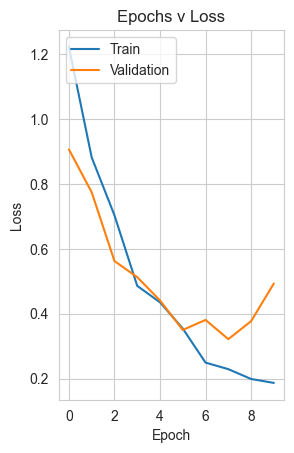

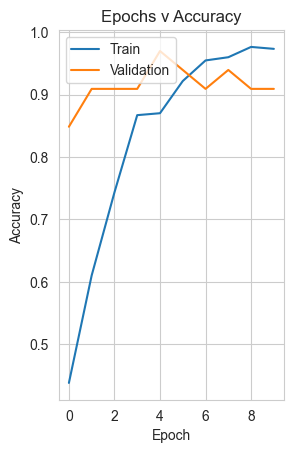

In [9]:
import tensorflow as tf
from keras import models
from keras import layers
import matplotlib.pyplot as plt
tf.keras.backend.clear_session()
from tensorflow.keras import regularizers

cnn_v1 = tf.keras.Sequential()
cnn_v1.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_1a'))
cnn_v1.add(layers.MaxPooling2D((2, 2)))
cnn_v1.add(layers.Dropout(0.3))

cnn_v1.add(layers.Flatten())
cnn_v1.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
cnn_v1.add(layers.Dropout(0.4))
cnn_v1.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
cnn_v1.add(layers.Dropout(0.4))
cnn_v1.add(layers.Dense(4, activation='softmax'))

cnn_v1.build(input_shape=(None, 32, 32, 1))
cnn_v1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_v1.summary()

cnn_v1_history = cnn_v1.fit(train_images, transformed_train_labels, epochs=25, validation_data=(val_images, transformed_val_labels),callbacks=[early_stopping],class_weight=class_weight_dict)
train_loss, train_acc = cnn_v1.evaluate(train_images, transformed_train_labels,verbose=1)
print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

val_loss, val_acc = cnn_v1.evaluate(val_images, transformed_val_labels,verbose=1)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')

plt.subplot(1, 2, 1)
plt.plot(cnn_v1_history.history['loss'])
plt.plot(cnn_v1_history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.subplot(1, 2, 2)
plt.plot(cnn_v1_history.history['accuracy'])
plt.plot(cnn_v1_history.history['val_accuracy'])
plt.title('Epochs v Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1a (Conv2D)                │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1b (Conv2D)                │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,336,740 (16.54 MB)

 Trainable params: 4,336,740 (16.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.3336 - loss: 1.3511 - val_accuracy: 0.8485 - val_loss: 0.8490
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.6603 - loss: 0.8883 - val_accuracy: 0.8788 - val_loss: 0.5315
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.7715 - loss: 0.6847 - val_accuracy: 0.9394 - val_loss: 0.3908
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.8872 - loss: 0.3800 - val_accuracy: 0.9394 - val_loss: 0.3788
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9387 - loss: 0.2864 - val_accuracy: 0.9394 - val_loss: 0.4350
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9540 - loss: 0.2754 - val_accuracy: 0.9394 - val_loss: 0.3441
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9580 - loss: 0.2014 - val_accuracy: 0.8788 - val_loss: 0.3497
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9509 - loss: 0.2170 - val_accuracy: 0.

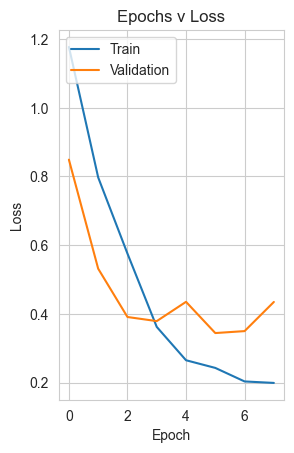

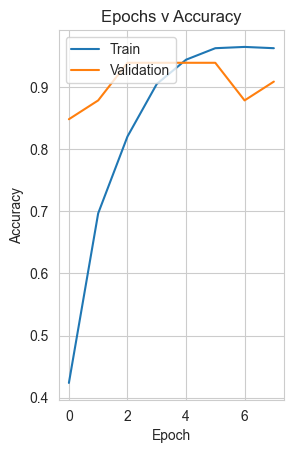

In [10]:
import tensorflow as tf
from keras import models
from keras import layers
tf.keras.backend.clear_session()
from tensorflow.keras import regularizers

cnn_v1_1 = tf.keras.Sequential()
cnn_v1_1.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_1a'))
cnn_v1_1.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_1b'))
cnn_v1_1.add(layers.MaxPooling2D((2, 2)))
cnn_v1_1.add(layers.Dropout(0.3))

cnn_v1_1.add(layers.Flatten())
cnn_v1_1.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
cnn_v1_1.add(layers.Dropout(0.4))
cnn_v1_1.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
cnn_v1_1.add(layers.Dropout(0.4))
cnn_v1_1.add(layers.Dense(4, activation='softmax'))

cnn_v1_1.build(input_shape=(None, 32, 32, 1))
cnn_v1_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_v1_1.summary()

cnn_v1_1_history = cnn_v1_1.fit(train_images, transformed_train_labels, epochs=25, validation_data=(val_images, transformed_val_labels),callbacks=[early_stopping],class_weight=class_weight_dict)
train_loss, train_acc = cnn_v1_1.evaluate(train_images, transformed_train_labels,verbose=1)
print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

val_loss, val_acc = cnn_v1_1.evaluate(val_images, transformed_val_labels,verbose=1)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')

plt.subplot(1, 2, 1)
plt.plot(cnn_v1_1_history.history['loss'])
plt.plot(cnn_v1_1_history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.subplot(1, 2, 2)
plt.plot(cnn_v1_1_history.history['accuracy'])
plt.plot(cnn_v1_1_history.history['val_accuracy'])
plt.title('Epochs v Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1a (Conv2D)                │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1b (Conv2D)                │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2a (Conv2D)                │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2b (Conv2D)                │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,295,012 (8.75 MB)

 Trainable params: 2,295,012 (8.75 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.2910 - loss: 1.4603 - val_accuracy: 0.6970 - val_loss: 0.9852
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.5597 - loss: 1.0052 - val_accuracy: 0.6364 - val_loss: 0.8583
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.6913 - loss: 0.8620 - val_accuracy: 0.8485 - val_loss: 0.5055
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.7745 - loss: 0.6647 - val_accuracy: 0.8485 - val_loss: 0.4869
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.8024 - loss: 0.5787 - val_accuracy: 0.9091 - val_loss: 0.4006
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.8485 - loss: 0.4210 - val_accuracy: 0.9091 - val_loss: 0.4698
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.9052 - loss: 0.3727 - val_accuracy: 0.9091 - val_loss: 0.3430
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9130 - loss: 0.3174 - val_accuracy: 0.

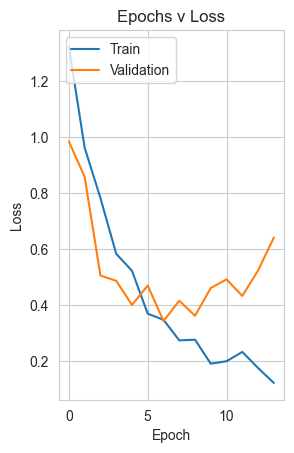

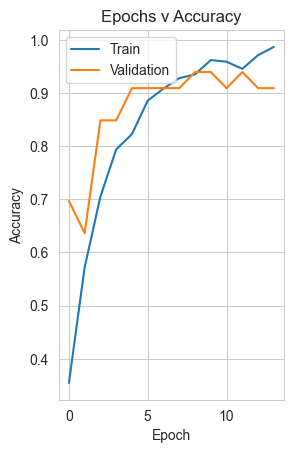

In [11]:
import tensorflow as tf
from keras import layers
from tensorflow.keras import regularizers

tf.keras.backend.clear_session()

cnn_v2 = tf.keras.Sequential()
cnn_v2.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_1a'))
cnn_v2.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_1b'))
cnn_v2.add(layers.MaxPooling2D((2, 2)))
cnn_v2.add(layers.Dropout(0.3))

cnn_v2.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_2a'))
cnn_v2.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_2b'))
cnn_v2.add(layers.MaxPooling2D((2, 2)))
cnn_v2.add(layers.Dropout(0.3))

cnn_v2.add(layers.Flatten())
cnn_v2.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
cnn_v2.add(layers.Dropout(0.4))
cnn_v2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
cnn_v2.add(layers.Dropout(0.4))
cnn_v2.add(layers.Dense(4, activation='softmax'))

cnn_v2.build(input_shape=(None, 32, 32, 1))
cnn_v2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_v2.summary()

cnn_v2_history = cnn_v2.fit(train_images, transformed_train_labels, epochs=25, validation_data=(val_images, transformed_val_labels),callbacks=[early_stopping],class_weight=class_weight_dict)
train_loss, train_acc = cnn_v2.evaluate(train_images, transformed_train_labels,verbose=1)
print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

val_loss, val_acc = cnn_v2.evaluate(val_images, transformed_val_labels,verbose=1)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')

plt.subplot(1, 2, 1)
plt.plot(cnn_v2_history.history['loss'])
plt.plot(cnn_v2_history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.subplot(1, 2, 2)
plt.plot(cnn_v2_history.history['accuracy'])
plt.plot(cnn_v2_history.history['val_accuracy'])
plt.title('Epochs v Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.2210 - loss: 1.5080 - val_accuracy: 0.4242 - val_loss: 1.4411
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.3581 - loss: 1.3751 - val_accuracy: 0.4242 - val_loss: 1.2398
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.4786 - loss: 1.1396 - val_accuracy: 0.7576 - val_loss: 0.8688
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.6940 - loss: 0.8278 - val_accuracy: 0.8485 - val_loss: 0.6189
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.7476 - loss: 0.7070 - val_accuracy: 0.8182 - val_loss: 0.5877
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.7703 - loss: 0.6730 - val_accuracy: 0.8788 - val_loss: 0.4811
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.7896 - loss: 0.6124 - val_accuracy: 0.7879 - val_loss: 0.6736
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.7787 - loss: 0.6207 - val_accuracy: 0.878

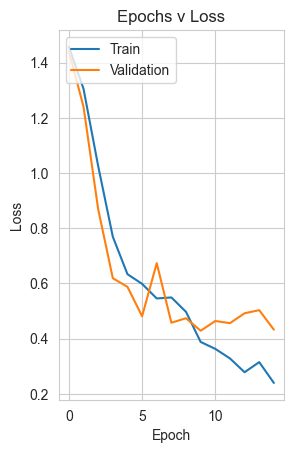

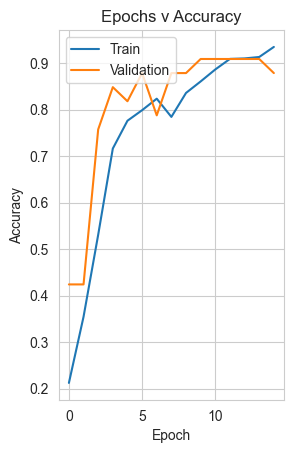

In [12]:
import tensorflow as tf
from keras import layers
from tensorflow.keras import regularizers

tf.keras.backend.clear_session()

cnn_v3 = tf.keras.Sequential()
cnn_v3.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_1a'))
cnn_v3.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_1b'))
cnn_v3.add(layers.MaxPooling2D((2, 2)))
cnn_v3.add(layers.Dropout(0.3))

cnn_v3.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_2a'))
cnn_v3.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_2b'))
cnn_v3.add(layers.MaxPooling2D((2, 2)))
cnn_v3.add(layers.Dropout(0.3))

cnn_v3.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv_3a'))
cnn_v3.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv_3b'))
cnn_v3.add(layers.MaxPooling2D((2, 2)))
cnn_v3.add(layers.Flatten())
cnn_v3.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
cnn_v3.add(layers.Dropout(0.4))
cnn_v3.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
cnn_v3.add(layers.Dropout(0.4))
cnn_v3.add(layers.Dense(4, activation='softmax'))

cnn_v3.build(input_shape=(None, 32, 32, 1))
cnn_v3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_v3_history = cnn_v3.fit(train_images, transformed_train_labels, epochs=25, validation_data=(val_images, transformed_val_labels),callbacks=[early_stopping],class_weight=class_weight_dict)
train_loss, train_acc = cnn_v3.evaluate(train_images, transformed_train_labels,verbose=1)
print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

val_loss, val_acc = cnn_v3.evaluate(val_images, transformed_val_labels,verbose=1)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')

plt.subplot(1, 2, 1)
plt.plot(cnn_v3_history.history['loss'])
plt.plot(cnn_v3_history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.subplot(1, 2, 2)
plt.plot(cnn_v3_history.history['accuracy'])
plt.plot(cnn_v3_history.history['val_accuracy'])
plt.title('Epochs v Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
cnn_v1.build(input_shape=(None, 32, 32, 1))
cnn_v1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
cnn_v1_1.build(input_shape=(None, 32, 32, 1))
cnn_v1_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
cnn_v2.build(input_shape=(None, 32, 32, 1))
cnn_v2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
cnn_v3.build(input_shape=(None, 32, 32, 1))
cnn_v3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
cnn_v1.summary()

In [ ]:
cnn_v1_1.summary()

In [ ]:
cnn_v2.summary()

In [18]:
cnn_v3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1a (Conv2D)                │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1b (Conv2D)                │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2a (Conv2D)                │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2b (Conv2D)                │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3a (Conv2D)                │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3b (Conv2D)                │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,403,630 (16.80 MB)

 Trainable params: 1,467,876 (5.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,935,754 (11.20 MB)

In [ ]:
cnn_v1_history = cnn_v1.fit(train_images, transformed_train_labels, epochs=25, validation_data=(val_images, transformed_val_labels),callbacks=[early_stopping],class_weight=class_weight_dict)
train_loss, train_acc = cnn_v1.evaluate(train_images, transformed_train_labels,verbose=1)
print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

val_loss, val_acc = cnn_v1.evaluate(val_images, transformed_val_labels,verbose=1)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')

In [ ]:
cnn_v1_1_history = cnn_v1_1.fit(train_images, transformed_train_labels, epochs=25, validation_data=(val_images, transformed_val_labels),callbacks=[early_stopping],class_weight=class_weight_dict)
train_loss, train_acc = cnn_v1_1.evaluate(train_images, transformed_train_labels,verbose=1)
print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

val_loss, val_acc = cnn_v1_1.evaluate(val_images, transformed_val_labels,verbose=1)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')

In [ ]:
cnn_v2_history = cnn_v2.fit(train_images, transformed_train_labels, epochs=25, validation_data=(val_images, transformed_val_labels),callbacks=[early_stopping],class_weight=class_weight_dict)
train_loss, train_acc = cnn_v2.evaluate(train_images, transformed_train_labels,verbose=1)
print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

val_loss, val_acc = cnn_v2.evaluate(val_images, transformed_val_labels,verbose=1)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')

In [ ]:
cnn_v3_history = cnn_v3.fit(train_images, transformed_train_labels, epochs=25, validation_data=(val_images, transformed_val_labels),callbacks=[early_stopping],class_weight=class_weight_dict)
train_loss, train_acc = cnn_v3.evaluate(train_images, transformed_train_labels,verbose=1)
print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

val_loss, val_acc = cnn_v3.evaluate(val_images, transformed_val_labels,verbose=1)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')


In [ ]:
test_loss, test_acc = cnn_v1.evaluate(test_images, transformed_test_labels,verbose=1)
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

In [ ]:
test_loss, test_acc = cnn_v1_1.evaluate(test_images, transformed_test_labels,verbose=1)
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

In [ ]:
test_loss, test_acc = cnn_v2.evaluate(test_images, transformed_test_labels,verbose=1)
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

In [ ]:
test_loss, test_acc = cnn_v3.evaluate(test_images, transformed_test_labels,verbose=1)
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

In [ ]:
from sklearn.metrics import classification_report

y_pred = cnn_v1.predict(val_images)
y_pred_classes_1 = np.argmax(y_pred, axis=1)
print(classification_report(transformed_val_labels, y_pred_classes_1))

In [ ]:
from sklearn.metrics import classification_report

y_pred = cnn_v2.predict(val_images)
y_pred_classes_2 = np.argmax(y_pred, axis=1)
print(classification_report(transformed_val_labels, y_pred_classes_2))

In [ ]:
from sklearn.metrics import classification_report

y_pred = cnn_v3.predict(val_images)
y_pred_classes_3 = np.argmax(y_pred, axis=1)
print(classification_report(transformed_val_labels, y_pred_classes_3))

In [ ]:
from sklearn.metrics import classification_report

y_pred = cnn_v2.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(transformed_test_labels, y_pred_classes))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate confusion matrix
cm = confusion_matrix(transformed_val_labels, y_pred_classes_1)

# Get class names from the label encoder
class_names = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate confusion matrix
cm = confusion_matrix(transformed_val_labels, y_pred_classes_2)

# Get class names from the label encoder
class_names = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate confusion matrix
cm = confusion_matrix(transformed_val_labels, y_pred_classes_3)

# Get class names from the label encoder
class_names = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
cnn_feature_extractor = tf.keras.Model(inputs=cnn_v2.inputs, outputs=cnn_v2.get_layer('dense_1').output)
train_cnn_features = cnn_feature_extractor.predict(train_images)
train_cnn_features = train_cnn_features.reshape(train_cnn_features.shape[0], -1)
val_cnn_features = cnn_feature_extractor.predict(val_images)
val_cnn_features = val_cnn_features.reshape(val_cnn_features.shape[0], -1)
test_cnn_features = cnn_feature_extractor.predict(test_images)
test_cnn_features = test_cnn_features.reshape(test_cnn_features.shape[0], -1)

In [ ]:
print(train_cnn_features.shape)
print(val_cnn_features.shape)
print(test_cnn_features.shape)

In [ ]:
print(train_images.shape)
raw_features_shape = train_images[:,:,:,0].shape[1] * train_images.shape[2] * train_images.shape[3]
print(f'Total number of features used for Decision Forests: {raw_features_shape}')

In [ ]:
X_train_rf = train_images.reshape(train_images.shape[0],raw_features_shape)
X_val_rf = val_images.reshape(val_images.shape[0],raw_features_shape)
X_test_rf = test_images.reshape(test_images.shape[0],raw_features_shape)

print(f'Shape of training, val, test images: {X_train_rf.shape}, {X_val_rf.shape}, {X_test_rf.shape}')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
random_forest_model = RandomForestClassifier(n_estimators=100,max_features='sqrt',max_depth=8,class_weight='balanced',random_state=42)
rf_history = random_forest_model.fit(X_train_rf, transformed_train_labels)

rf_train_pred = rf_history.predict(X_train_rf)
print(f'Train accuracy: {accuracy_score(transformed_train_labels, rf_train_pred)}')

rf_val_pred = rf_history.predict(X_val_rf)
print(f'Validation accuracy: {accuracy_score(transformed_val_labels, rf_val_pred)}')

rf_test_pred = rf_history.predict(X_test_rf)
print(f'Test accuracy: {accuracy_score(transformed_test_labels, rf_test_pred)}')

In [ ]:
# Implementation of RF-CNN model
random_forest_model_1 = RandomForestClassifier(n_estimators=100,max_features='sqrt',max_depth=8,class_weight='balanced',random_state=42)
rf_history = random_forest_model_1.fit(train_cnn_features, transformed_train_labels)

rf_cnn_train_pred = rf_history.predict(train_cnn_features)
print(f'Train accuracy: {accuracy_score(transformed_train_labels, rf_cnn_train_pred)}')

rf_cnn_val_pred = rf_history.predict(val_cnn_features)
print(f'Validation accuracy: {accuracy_score(transformed_val_labels, rf_cnn_val_pred)}')

rf_test_pred = rf_history.predict(test_cnn_features)
print(f'Test accuracy: {accuracy_score(transformed_test_labels, rf_test_pred)}')

In [ ]:
cnn_train_acc = cnn_v2_history.history['accuracy']
cnn_val_acc = cnn_v2_history.history['val_accuracy']

plt.plot(cnn_train_acc, label='Train_accuracy')
plt.plot(cnn_val_acc, label='Val_accuracy')

plt.ylabel('Accuracy')
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [13]:
img_res=(32, 32, 32)
train_image_data = loaded_train_data.reshape((len(loaded_train_data), img_res[0], img_res[1], img_res[2], 1))
val_image_data = loaded_val_data.reshape((len(loaded_val_data), img_res[0], img_res[1], img_res[2], 1))
test_image_data = loaded_test_data.reshape((len(loaded_test_data), img_res[0], img_res[1], img_res[2], 1))
print(train_image_data.shape, val_image_data.shape,test_image_data.shape)

(970, 32, 32, 32, 1) (33, 32, 32, 32, 1) (33, 32, 32, 32, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1a (Conv3D)                │ (None, 32, 32, 32, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 16, 16, 16, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 16, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    67,109,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,112,324 (256.01 MB)

 Trainable params: 67,112,324 (256.01 MB)

 Non-trainable params: 0 (0.00 B)

(970, 32, 32, 32, 1) (970,) (33, 32, 32, 32, 1) (33,)
Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.3841 - loss: 7.8522 - val_accuracy: 0.6970 - val_loss: 0.7440
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.8095 - loss: 0.5632 - val_accuracy: 0.8182 - val_loss: 0.5369
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9357 - loss: 0.2822 - val_accuracy: 0.8485 - val_loss: 0.4427
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9856 - loss: 0.1369 - val_accuracy: 0.9091 - val_loss: 0.3937
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9908 - loss: 0.0736 - val_accuracy: 0.9697 - val_loss: 0.3443
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.9954 - loss: 0.0474 - val_accuracy: 0.9091 - val_loss: 0.3633
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 1.0000 - loss: 0.0296 - val_accuracy: 0.8788 - val_loss: 0.3937
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 1.

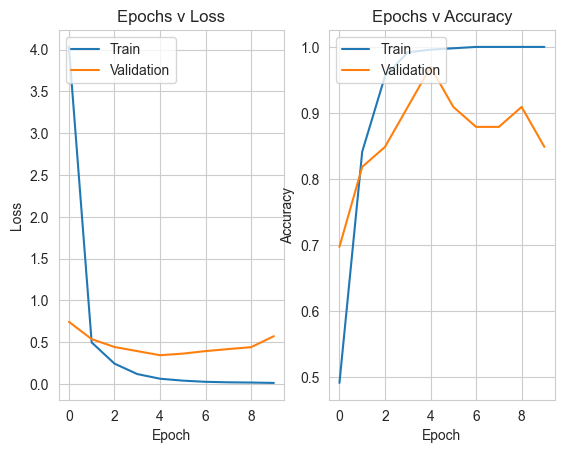

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - accuracy: 0.9895 - loss: 0.0688
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9694 - loss: 0.3435 

Train Accuracy: 0.99
Validation Accuracy: 0.97


In [14]:
import matplotlib.pyplot as plt

#Establish number of classes we need to predict
classes = 4
#Hyperparameters
lr = 0.001
# initialize model
cnn_3D_v1 = tf.keras.Sequential()

# add convolutional layer
cnn_3D_v1.add(layers.Conv3D(
  filters=32,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_1a',
  activation='relu'
))

cnn_3D_v1.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

# add dropout layer
cnn_3D_v1.add(layers.Dropout(rate=0.4))

# add a flattening layer
cnn_3D_v1.add(layers.Flatten())

# add a Dense Layer
cnn_3D_v1.add(layers.Dense(units=512, activation='relu'))

# add the classification layer
cnn_3D_v1.add(layers.Dense(units=classes, activation='softmax',kernel_regularizer=regularizers.l2(1e-4))) #4 classes (softmax for multi-class)

# build and compile model
cnn_3D_v1.build(input_shape=(None, 32, 32, 32, 1))
cnn_3D_v1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), #Since we are using Sparse encodings (not One-Hot Dense....)
              metrics=['accuracy'])

# print model_tf summary
cnn_3D_v1.summary()

# train model_tf on (X_train, y_train) data
print(train_image_data.shape, transformed_train_labels.shape,val_image_data.shape, transformed_val_labels.shape)
cnn_3D_v1_history = cnn_3D_v1.fit(
    train_image_data,
    transformed_train_labels,
    validation_data=(val_image_data, transformed_val_labels),
    epochs=15,
    callbacks=[early_stopping]
)

# plot loss curves

plt.subplot(1, 2, 1)
plt.plot(cnn_3D_v1_history.history['loss'])
plt.plot(cnn_3D_v1_history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(cnn_3D_v1_history.history['accuracy'])
plt.plot(cnn_3D_v1_history.history['val_accuracy'])
plt.title('Epochs v Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
train_loss, train_acc = cnn_3D_v1.evaluate(train_image_data, transformed_train_labels, verbose=1)
val_loss, val_acc = cnn_3D_v1.evaluate(val_image_data, transformed_val_labels, verbose=1)

print(f"\nTrain Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1a (Conv3D)                │ (None, 32, 32, 32, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1b (Conv3D)                │ (None, 32, 32, 32, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 16, 16, 16, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 16, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    67,109,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,140,004 (256.12 MB)

 Trainable params: 67,140,004 (256.12 MB)

 Non-trainable params: 0 (0.00 B)

(970, 32, 32, 32, 1) (970,) (33, 32, 32, 32, 1) (33,)
Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 157s 5s/step - accuracy: 0.2676 - loss: 5.2332 - val_accuracy: 0.4242 - val_loss: 1.3749
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 153s 5s/step - accuracy: 0.4327 - loss: 1.3680 - val_accuracy: 0.4242 - val_loss: 1.3478
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 152s 5s/step - accuracy: 0.4327 - loss: 1.3394 - val_accuracy: 0.4242 - val_loss: 1.3184
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 153s 5s/step - accuracy: 0.4327 - loss: 1.3101 - val_accuracy: 0.4242 - val_loss: 1.2939
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 163s 5s/step - accuracy: 0.4327 - loss: 1.2872 - val_accuracy: 0.4242 - val_loss: 1.2792
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 155s 5s/step - accuracy: 0.4327 - loss: 1.2748 - val_accuracy: 0.4242 - val_loss: 1.2730
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


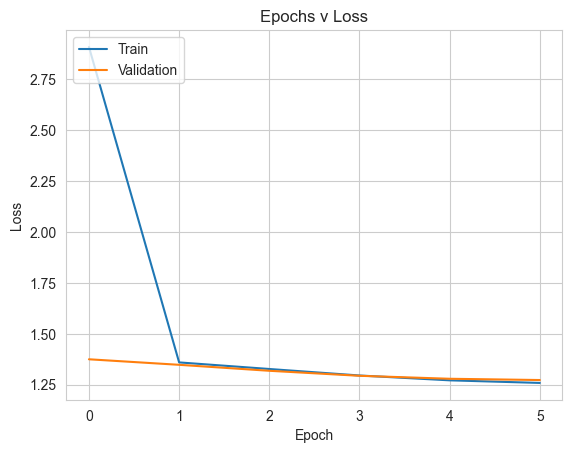

31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 549ms/step - accuracy: 0.3956 - loss: 1.3767
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.4287 - loss: 1.3743

Train Accuracy: 0.45
Validation Accuracy: 0.42


In [16]:
import matplotlib.pyplot as plt

#Establish number of classes we need to predict
classes = 4
#Hyperparameters
lr = 0.001
# initialize model
tf.keras.backend.clear_session()

cnn_3D_v2 = tf.keras.Sequential()

# add convolutional layer
cnn_3D_v2.add(layers.Conv3D(
  filters=32,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_1a',
  activation='relu'
))

cnn_3D_v2.add(layers.Conv3D(
  filters=32,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_1b',
  activation='relu'
))
cnn_3D_v2.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

# add dropout layer
cnn_3D_v2.add(layers.Dropout(rate=0.4))

# add a flattening layer
cnn_3D_v2.add(layers.Flatten())

# add a Dense Layer
cnn_3D_v2.add(layers.Dense(units=512, activation='relu'))

# add the classification layer
cnn_3D_v2.add(layers.Dense(units=classes, activation='softmax',kernel_regularizer=regularizers.l2(1e-4))) #4 classes (softmax for multi-class)

# build and compile model
cnn_3D_v2.build(input_shape=(None, 32, 32, 32, 1))
cnn_3D_v2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), #Since we are using Sparse encodings (not One-Hot Dense....)
              metrics=['accuracy'])

# print model_tf summary
cnn_3D_v2.summary()

# train model_tf on (X_train, y_train) data
print(train_image_data.shape, transformed_train_labels.shape,val_image_data.shape, transformed_val_labels.shape)
history = cnn_3D_v2.fit(
    train_image_data,
    transformed_train_labels,
    validation_data=(val_image_data, transformed_val_labels),
    epochs=15,
    callbacks=[early_stopping]
)

# plot loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
train_loss, train_acc = cnn_3D_v2.evaluate(train_image_data, transformed_train_labels, verbose=1)
val_loss, val_acc = cnn_3D_v2.evaluate(val_image_data, transformed_val_labels, verbose=1)

print(f"\nTrain Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1a (Conv3D)                │ (None, 32, 32, 32, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1b (Conv3D)                │ (None, 32, 32, 32, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 16, 16, 16, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2a (Conv3D)                │ (None, 16, 16, 16, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2b (Conv3D)                │ (None, 16, 16, 16, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 8, 8, 8, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 8, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,974,372 (64.75 MB)

 Trainable params: 16,974,372 (64.75 MB)

 Non-trainable params: 0 (0.00 B)

(970, 32, 32, 32, 1) (970,) (33, 32, 32, 32, 1) (33,)
Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 199s 6s/step - accuracy: 0.4155 - loss: 1.3693 - val_accuracy: 0.6970 - val_loss: 0.8599
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 203s 7s/step - accuracy: 0.6842 - loss: 0.7983 - val_accuracy: 0.7576 - val_loss: 0.6280
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 226s 7s/step - accuracy: 0.7915 - loss: 0.5552 - val_accuracy: 0.7576 - val_loss: 0.6003
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 214s 7s/step - accuracy: 0.8864 - loss: 0.3116 - val_accuracy: 0.8182 - val_loss: 0.4916
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 215s 7s/step - accuracy: 0.9206 - loss: 0.2053 - val_accuracy: 0.8485 - val_loss: 0.5170
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 312s 10s/step - accuracy: 0.9550 - loss: 0.1033 - val_accuracy: 0.8485 - val_loss: 0.3257
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 268s 9s/step - accuracy: 0.9650 - loss: 0.0851 - val_accuracy: 0.8788 - val_loss: 0.3085
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 204s 6s/step - acc

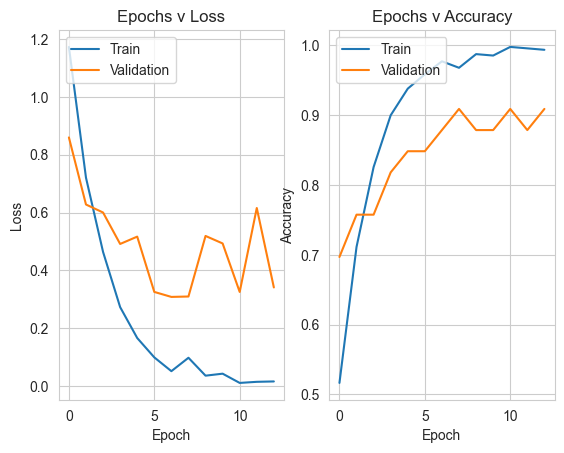

31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 718ms/step - accuracy: 0.9907 - loss: 0.0396
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9081 - loss: 0.3126

Train Accuracy: 0.99
Validation Accuracy: 0.91


In [15]:
import matplotlib.pyplot as plt

#Establish number of classes we need to predict
classes = 4
#Hyperparameters
lr = 0.001
tf.keras.backend.clear_session()

# initialize model
cnn_3D_v3 = tf.keras.Sequential()

# add convolutional layer
cnn_3D_v3.add(layers.Conv3D(
  filters=32,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_1a',
  activation='relu'
))

cnn_3D_v3.add(layers.Conv3D(
  filters=32,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_1b',
  activation='relu'
))
cnn_3D_v3.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

cnn_3D_v3.add(layers.Conv3D(
  filters=64,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_2a',
  activation='relu'
))
cnn_3D_v3.add(layers.Conv3D(
  filters=64,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_2b',
  activation='relu'
))
cnn_3D_v3.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

# add dropout layer
cnn_3D_v3.add(layers.Dropout(rate=0.4))

# add a flattening layer
cnn_3D_v3.add(layers.Flatten())

# add a Dense Layer
cnn_3D_v3.add(layers.Dense(units=512, activation='relu'))

# add the classification layer
cnn_3D_v3.add(layers.Dense(units=classes, activation='softmax',kernel_regularizer=regularizers.l2(1e-4))) #4 classes (softmax for multi-class)

# build and compile model
cnn_3D_v3.build(input_shape=(None, 32, 32, 32, 1))
cnn_3D_v3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), #Since we are using Sparse encodings (not One-Hot Dense....)
              metrics=['accuracy'])

# print model_tf summary
cnn_3D_v3.summary()

# train model_tf on (X_train, y_train) data
print(train_image_data.shape, transformed_train_labels.shape,val_image_data.shape, transformed_val_labels.shape)
cnn_3D_v3_history = cnn_3D_v3.fit(
    train_image_data,
    transformed_train_labels,
    validation_data=(val_image_data, transformed_val_labels),
    epochs=15,
    callbacks=[early_stopping]
)

# plot loss curves
plt.subplot(1, 2, 1)
plt.plot(cnn_3D_v3_history.history['loss'])
plt.plot(cnn_3D_v3_history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(cnn_3D_v3_history.history['accuracy'])
plt.plot(cnn_3D_v3_history.history['val_accuracy'])
plt.title('Epochs v Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
train_loss, train_acc = cnn_3D_v3.evaluate(train_image_data, transformed_train_labels, verbose=1)
val_loss, val_acc = cnn_3D_v3.evaluate(val_image_data, transformed_val_labels, verbose=1)

print(f"\nTrain Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1a (Conv3D)                │ (None, 32, 32, 32, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1b (Conv3D)                │ (None, 32, 32, 32, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 16, 16, 16, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2a (Conv3D)                │ (None, 16, 16, 16, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2b (Conv3D)                │ (None, 16, 16, 16, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 8, 8, 8, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 8, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3a (Conv3D)                │ (None, 8, 8, 8, 128)   │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3b (Conv3D)                │ (None, 8, 8, 8, 128)   │       442,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,415,396 (131.28 MB)

 Trainable params: 34,415,396 (131.28 MB)

 Non-trainable params: 0 (0.00 B)

(970, 32, 32, 32, 1) (970,) (33, 32, 32, 32, 1) (33,)
Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 225s 7s/step - accuracy: 0.3928 - loss: 1.8099 - val_accuracy: 0.4242 - val_loss: 1.2248
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 216s 7s/step - accuracy: 0.5630 - loss: 1.1318 - val_accuracy: 0.7273 - val_loss: 0.7999
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 215s 7s/step - accuracy: 0.6826 - loss: 0.7692 - val_accuracy: 0.7576 - val_loss: 0.7064
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 215s 7s/step - accuracy: 0.7428 - loss: 0.6299 - val_accuracy: 0.7273 - val_loss: 0.7697
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 216s 7s/step - accuracy: 0.8237 - loss: 0.4539 - val_accuracy: 0.7576 - val_loss: 0.6335
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 215s 7s/step - accuracy: 0.8870 - loss: 0.2584 - val_accuracy: 0.7273 - val_loss: 1.0404
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 215s 7s/step - accuracy: 0.9362 - loss: 0.1990 - val_accuracy: 0.6970 - val_loss: 0.8950
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 221s 7s/step - accu

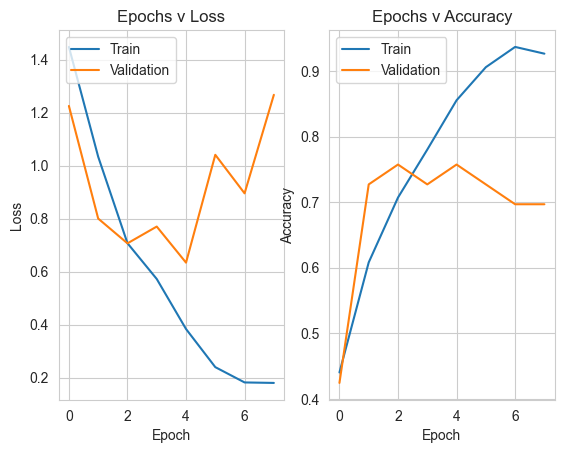

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 827ms/step - accuracy: 0.7213 - loss: 0.6740
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.7655 - loss: 0.6944

Train Accuracy: 0.77
Validation Accuracy: 0.76


In [17]:
import matplotlib.pyplot as plt

#Establish number of classes we need to predict
classes = 4
#Hyperparameters
lr = 0.001
tf.keras.backend.clear_session()

# initialize model
cnn_3D_v4 = tf.keras.Sequential()

# add convolutional layer
cnn_3D_v4.add(layers.Conv3D(
  filters=32,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_1a',
  activation='relu'
))

cnn_3D_v4.add(layers.Conv3D(
  filters=32,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_1b',
  activation='relu'
))
cnn_3D_v4.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

cnn_3D_v4.add(layers.Conv3D(
  filters=64,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_2a',
  activation='relu'
))
cnn_3D_v4.add(layers.Conv3D(
  filters=64,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_2b',
  activation='relu'
))
cnn_3D_v4.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

# add dropout layer
cnn_3D_v4.add(layers.Dropout(rate=0.4))

cnn_3D_v4.add(layers.Conv3D(
  filters=128,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_3a',
  activation='relu'
))
cnn_3D_v4.add(layers.Conv3D(
  filters=128,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_3b',
  activation='relu'
))

# add a flattening layer
cnn_3D_v4.add(layers.Flatten())

# add a Dense Layer
cnn_3D_v4.add(layers.Dense(units=512, activation='relu'))

# add the classification layer
cnn_3D_v4.add(layers.Dense(units=classes, activation='softmax',kernel_regularizer=regularizers.l2(1e-4))) #4 classes (softmax for multi-class)

# build and compile model
cnn_3D_v4.build(input_shape=(None, 32, 32, 32, 1))
cnn_3D_v4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), #Since we are using Sparse encodings (not One-Hot Dense....)
              metrics=['accuracy'])

# print model_tf summary
cnn_3D_v4.summary()

# train model_tf on (X_train, y_train) data
print(train_image_data.shape, transformed_train_labels.shape,val_image_data.shape, transformed_val_labels.shape)
cnn_3D_v4_history = cnn_3D_v4.fit(
    train_image_data,
    transformed_train_labels,
    validation_data=(val_image_data, transformed_val_labels),
    epochs=15,
    callbacks=[early_stopping]
)

# plot loss curves
plt.subplot(1, 2, 1)
plt.plot(cnn_3D_v4_history.history['loss'])
plt.plot(cnn_3D_v4_history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(cnn_3D_v4_history.history['accuracy'])
plt.plot(cnn_3D_v4_history.history['val_accuracy'])
plt.title('Epochs v Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
train_loss, train_acc = cnn_3D_v4.evaluate(train_image_data, transformed_train_labels, verbose=1)
val_loss, val_acc = cnn_3D_v4.evaluate(val_image_data, transformed_val_labels, verbose=1)

print(f"\nTrain Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")

| Model  | Filters                        | Activation | Optimizer | Learning Rate | # Parameters | Training Accuracy | Validation Accuracy |
|--------|--------------------------------|------------|-----------|---------------|-------------|-------------------|---------------------|
| 2D CNN | [32]                           | relu       | Adam      | 0.001         | 4,327,492   | 91%               | 96%                 |
| 2D CNN | [(32, 32)]                     | relu       | Adam      | 0.001         | 4,336,740   | 93%               | 93%                 |
| 2D CNN | [(32, 32),(64, 64)]            | relu       | Adam      | 0.001         | 2,295,012   | 96%               | 93%                 |
| 2D CNN | [(32, 32),(64, 64), (128,128)] | relu       | Adam      | 0.001         | 4,403,630   | 91%               | 90%                 |
| 3D CNN | [32]                           | relu       | Adam      | 0.001         | 67,112,324  | 99%               | 97%                 |
| 3D CNN | [(32, 32)]                     | relu       | Adam      | 0.001         | 67,140,004  | 45%               | 42%                 |
| 3D CNN | [(32, 32),(64, 64)]            | relu       | Adam      | 0.001         | 16,974,372  | 99%               | 91%                 |
| 3D CNN | [(32, 32),(64, 64), (128,128)] | relu       | Adam      | 0.001         |             | 77%               | 76%                 |



In [ ]:
test_loss, test_acc = model_tf.evaluate(test_image_data, transformed_test_labels, verbose=1)
print(f"Test Accuracy: {test_acc:.2f}")


| Model | Hidden units  | Activation | Optimizer | Learning Rate | # Parameters | Training Accuracy | Validation Accuracy |
|-------|---------------|------------|-----------|---------------|--------------|-------------------|---------------------|
| FFNN  | [128]         | tanh       | SGD       | 0.01          | 131716       | 87.3%             | 84.9%               |
| FFNN  | [128]         | relu       | SGD       | 0.01          | 131716       | 86.4%             | 81.8%               |
| FFNN  | [128]         | relu       | Adam      | 0.01          | 131716       | 90.4%             | 81.8%               |
| FFNN  | [256,128]     | relu       | Adam      | 0.01          | 295812       | 71.5%             | 57.6%               |
| FFNN  | [256,128]     | relu       | Adam      | 0.001         | 295812       | 97.7%             | 87.9%               |
| FFNN  | [256,128]     | relu       | Adam      | 0.0001        | 689540       | 88.4%             | 84.9%               |
| FFNN  | [512,256,128] | relu       | Adam      | 0.01          | 689540       | 29.4%             | 27.3%               |
| FFNN  | [512,256,128] | relu       | Adam      | 0.001         | 689540       | 96.7%             | 90.9%               |
| FFNN  | [512,256,128] | relu       | Adam      | 0.0001        | 689540       | 89.7%             | 87.6%               |
| FFNN  | [512,256,128] | tanh       | SGD       | 0.0001        | 689540       | 37.7%             | 51.5%               |
| FFNN  | [512,256,128] | relu       | SGD       | 0.0001        | 689540       | 25.8%             | 48.5%               |